In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [2]:
tumor_dir=r'D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor'
healthy_dir=r'D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brain Tumor Data Set\Brain Tumor Data Set\Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brai...  cancer
1  D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brai...  cancer
2  D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brai...  cancer
3  D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brai...  cancer
4  D:\AI\DR_Hesham_Felouat\Course_DL\DataSet\Brai...  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


In [3]:
#shape of datatset
tumor_df.shape

(4600, 2)

In [4]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [5]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


In [6]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


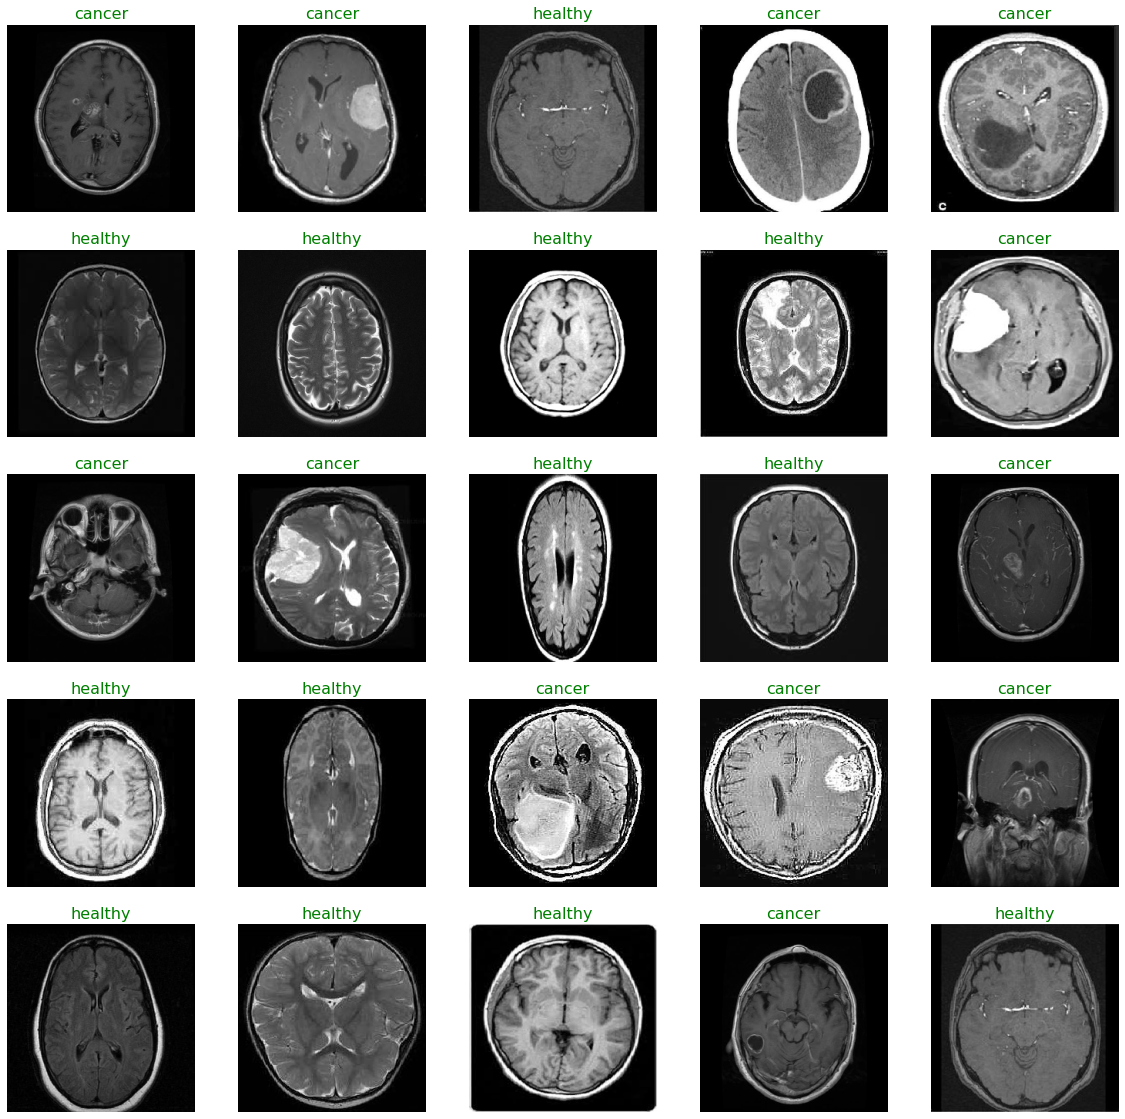

In [8]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

show_brain_images(train)

In [14]:
!pip install graphviz

In [16]:
#Defining Sequential Model
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))
#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 468512)            0         
                                                                 
 dense_15 (Dense)            (None, 128)               59969664  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                      

In [ ]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
116/116 [==============================] - 1148s 10s/step - loss: 2.1168 - accuracy: 0.6751 - val_loss: 0.3693 - val_accuracy: 0.8692
Epoch 2/10
116/116 [==============================] - 29s 247ms/step - loss: 0.3481 - accuracy: 0.8585 - val_loss: 0.2137 - val_accuracy: 0.9092
Epoch 3/10
116/116 [==============================] - 28s 245ms/step - loss: 0.1904 - accuracy: 0.9316 - val_loss: 0.1710 - val_accuracy: 0.9449
Epoch 4/10
116/116 [==============================] - 28s 245ms/step - loss: 0.1408 - accuracy: 0.9575 - val_loss: 0.1520 - val_accuracy: 0.9395
Epoch 5/10
116/116 [==============================] - 29s 248ms/step - loss: 0.1410 - accuracy: 0.9540 - val_loss: 0.0990 - val_accuracy: 0.9654
Epoch 6/10
116/116 [==============================] - 29s 247ms/step - loss: 0.0709 - accuracy: 0.9765 - val_loss: 0.0776 - val_accuracy: 0.9730
Epoch 7/10
116/116 [==============================] - 29s 251ms/step - loss: 0.0690 - accuracy: 0.9786 - val_loss: 0.1057 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

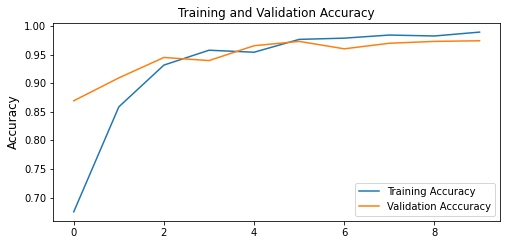

In [ ]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

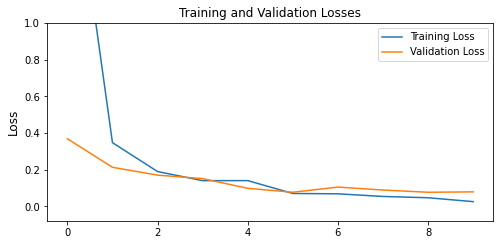

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)


44/44 [==============================] - 9s 193ms/step - loss: 0.0545 - accuracy: 0.9827


[0.054458148777484894, 0.9826964735984802]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.99      0.98      0.98       790
     healthy       0.97      0.99      0.98       597

    accuracy                           0.98      1387
   macro avg       0.98      0.98      0.98      1387
weighted avg       0.98      0.98      0.98      1387

Accuracy of the Model: 98.26964671953857 %


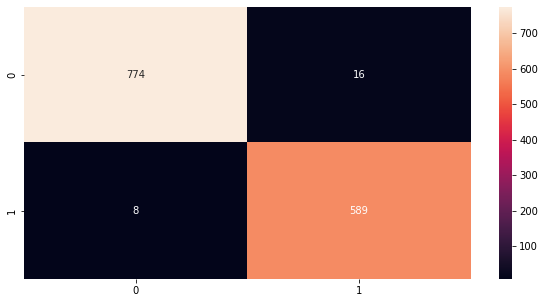

In [ ]:
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
# Save model
model.save("/content/drive/MyDrive/My_models/tumor_classification_model.h5")
print("Done ...")


In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.1 MB 7.8 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 11.7 MB/s 
     |████████████████████████████████| 2.3 MB 25.9 MB/s 
     |████████████████████████████████| 84 kB 1.3 MB/s 
     |████████████████████████████████| 54 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 46.2 MB/s 
     |████████████████████████████████| 55 kB 1.4 MB/s 
     |████████████████████████████████| 270 kB 48.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB 6.2 MB/s 
     |████████████████████████████████| 68 kB 5.5 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.0 MB 26.6 MB/s 
     |████████████████████████████████| 594 kB 44.

In [ ]:
# Loading the model
my_model = keras.models.load_model("/content/drive/MyDrive/My_models/tumor_classification_model.h5")
print("Done ...")

Done ...


In [ ]:
# https://www.gradio.app/ml_examples
!pip install gradio
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import requests
#from PIL import Image
import cv2

def inference(img):
    labels =["Tumor","Normal"]
    H,W,C = 244,244,3
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H, W)) 
    img = np.array(img)
    img = img.astype("float32")/255.0
    img = img.reshape(1,H,W,C)
    pred = my_model.predict(img).flatten()
    prediction = [pred[0], 1-pred[0]]
    dictionary = dict(zip(labels, map(float, prediction)))
    return dictionary


nbr_top_classes = 2
gr.Interface(fn=inference, 
             inputs=gr.inputs.Image(), 
             outputs=gr.outputs.Label(num_top_classes=nbr_top_classes),
             theme="darkdefault"
             ).launch(share=True) #, debug=True Use in Colab

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://25041.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f833b5bde50>,
 'http://127.0.0.1:7860/',
 'https://25041.gradio.app')